In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd 
#%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#import wordcloud
#from sqlalchemy import create_engine
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, LancasterStemmer,  PorterStemmer,WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import plotly.graph_objects as go
import plotly.express as px
import dateparser

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Femi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Femi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Femi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Femi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Femi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv("market_insider.csv")

In [5]:
df.shape

(2268, 5)

In [6]:
df.isnull().sum()

Source      0
Link        0
Title       0
Article    44
Date        0
dtype: int64

In [7]:
df = df.dropna()

Text pre-processing

In [8]:
#convert the date to datetime using dateparser
date = []

for i in df['Date']:
  date.append(dateparser.parse(i).strftime("%Y-%m-%d"))#remove the for loop and do it in one line 

df['Date'] = date  

In [9]:
# Cleaning
import re

def clean_statement(x):
    x = re.sub('-', ' ', x)
    x = re.sub('[,|.|?|\n]|\t', '', x)
    x = re.sub('n\'t', ' not', x)
    x = re.sub('All submissions for this problem are available', '', x)
    x = re.sub('Read problems statements in Mandarin Chinese|Russian|as well', '', x)
    x = re.sub('and|Vietnamese', '', x)
    x = re.sub(r"<[^>]*>", "", x) # Remove HTML tags and attributes
    x = re.sub(r"[^a-zA-Z0-9\s]", "", x) # Remove special characters and punctuation
    x = re.sub(r"\s+", " ", x) # Remove extra whitespace
    x = x.lower() # Convert the text to lowercase
    x = x + "."  # Add a full stop at the end of the text


    return x

In [12]:
df.head(1)

,Source,Link,Title,Article,Date
0,Markets Insider Automation,https://markets.businessinsider.com/news/stock...,Costco Wholesale hosts conference call for inv...,"The company, Costco Wholesale, is set to host ...",2023-05-09


In [10]:
#passing the dataframe throught the function
df['Title'] = [clean_statement(x) for x in df.Title.values]
df['Article'] = [clean_statement(x) for x in df.Article.values]
df.head()

,Source,Link,Title,Article,Date
0,Markets Insider Automation,https://markets.businessinsider.com/news/stock...,costco wholesale hosts conference call for inv...,the company costco wholesale is set to host in...,2023-05-10
1,InvestorPlace,https://markets.businessinsider.com/news/stock...,7 inflation proof stocks to buy for more bank ...,investorplace stock market news stock advice t...,2023-05-09
2,Zacks,https://markets.businessinsider.com/news/stock...,costco cost flat as market gains what you shou...,in the latest trading session costco cost clos...,2023-05-09
3,Zacks,https://markets.businessinsider.com/news/stock...,the zacks analyst blog highlights exxon mobil ...,for immediate releasechicago il may 8 2023 zac...,2023-05-09
4,Zacks,https://markets.businessinsider.com/news/stock...,top analyst reports for exxon mobil costco act...,friday may 5 2023the zacks research daily pres...,2023-05-06


In [11]:
#counts of occuring variables, useful for categorical features similar to .value_counts 
from collections import Counter
Counter(df['Source']).most_common()

[('InvestorPlace', 740),
 ('Benzinga', 434),
 ('Zacks', 244),
 ('MotleyFool', 228),
 ('PR Newswire', 171),
 ('TipRanks', 121),
 ('MarketWatch', 80),
 ('RTTNews', 79),
 ('Markets Insider Automation', 29),
 ('Market Watch', 26),
 ('Moodys', 22),
 ('USA Today', 17),
 ('Forbes', 16),
 ('GlobeNewswire', 5),
 ('CNBC', 4),
 ('New York Times', 2),
 ('Investors Business Daily', 2),
 ('Korea Times', 1),
 ('Business Times', 1),
 ('Financial Times', 1),
 ('Business Insider', 1)]

In [12]:
#define the stopwords 
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') + [
    '.',
    ',',
    '--',
    '\'s',
    '?',
    ')',
    '(',
    ':',
    '\'',
    '\'re',
    '"',
    '-',
    '}',
    '{',
    u'—',
    ']',
    '[',
    '...'
    ]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Femi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define the function to tokenize and remove stop words from the text
def process_text(dataframe, text_column, tokens_column):
    # Create a set of stop words
    stop_words = set(stopwords.words("english"))

    # Define a function to tokenize the text
    def tokenize_text(text):
        # Tokenize the text using NLTK's word_tokenize function
        tokens = word_tokenize(text)

        # Remove the stop words from the list of tokens
        filtered_tokens = [token for token in tokens if token not in stop_words]

        # Return the list of filtered tokens
        return filtered_tokens

    # Apply the tokenize_text function to the specified column
    dataframe[tokens_column] = dataframe[text_column].apply(tokenize_text)

In [14]:
process_text(df, 'Article', 'tokens_column')

In [15]:
import spacy

# Load the English language model from spaCy
nlp = spacy.load("en_core_web_sm")

# Define a function to lemmatize the words in a string of text
def lemmatize_text(text):
    # Parse the text using the spaCy English language model
    text_string = ' '.join(text)
    doc = nlp(text_string)

    # Use the lemmatize() method to lemmatize the words in the text
    lemmas = [token.lemma_ for token in doc]

    # Return the list of lemmas as a string
    return " ".join(lemmas)

# Apply the lemmatize_text function to the specified column
df["lemmas"] = df["tokens_column"].apply(lemmatize_text)

# Print the first few rows of the DataFrame to see the results
print(df.head())

                       Source   
0  Markets Insider Automation  \
1               InvestorPlace   
2                       Zacks   
3                       Zacks   
4                       Zacks   

                                                Link   
0  https://markets.businessinsider.com/news/stock...  \
1  https://markets.businessinsider.com/news/stock...   
2  https://markets.businessinsider.com/news/stock...   
3  https://markets.businessinsider.com/news/stock...   
4  https://markets.businessinsider.com/news/stock...   

                                               Title   
0  costco wholesale hosts conference call for inv...  \
1  7 inflation proof stocks to buy for more bank ...   
2  costco cost flat as market gains what you shou...   
3  the zacks analyst blog highlights exxon mobil ...   
4  top analyst reports for exxon mobil costco act...   

                                             Article        Date   
0  the company costco wholesale is set to host in...  2023-

In [16]:
#word cound
df['word_count'] = df['Article'].apply(lambda x: len(str(x).split()))

#unique word count
df['unique_word_count'] = df['Article'].apply(lambda x: len(set(str(x).split())))

#mean word lenght
df['mean_word_length'] = df['Article'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

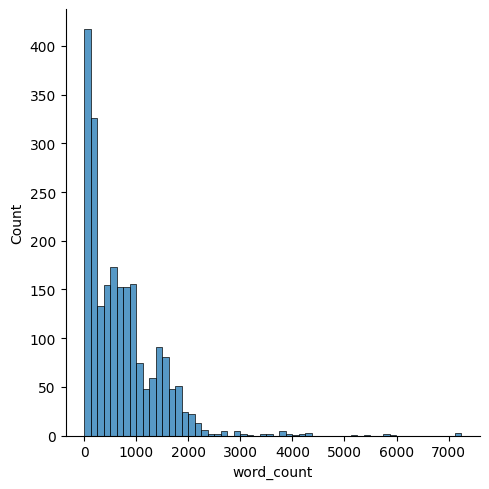

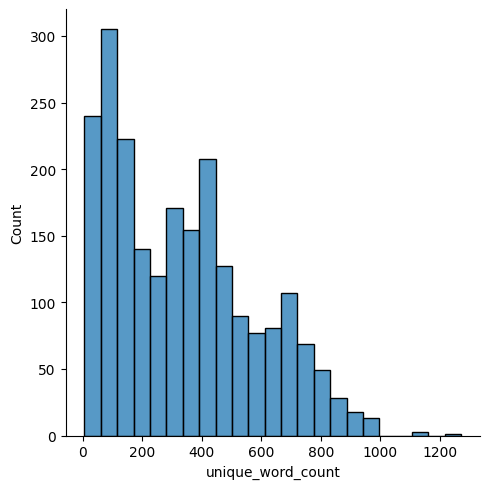

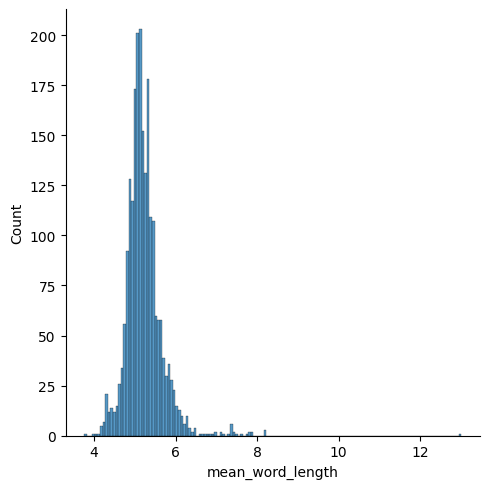

In [17]:
import seaborn as sns

sns.displot(df['word_count'])
sns.displot(df['unique_word_count'])
sns.displot(df['mean_word_length'])

In [18]:
#count of the authors over the years and their contributions 
df['Source'].value_counts()

Source
InvestorPlace                 740
Benzinga                      434
Zacks                         244
MotleyFool                    228
PR Newswire                   171
TipRanks                      121
MarketWatch                    80
RTTNews                        79
Markets Insider Automation     29
Market Watch                   26
Moodys                         22
USA Today                      17
Forbes                         16
GlobeNewswire                   5
CNBC                            4
New York Times                  2
Investors Business Daily        2
Korea Times                     1
Business Times                  1
Financial Times                 1
Business Insider                1
Name: count, dtype: int64

In [19]:
df['Source'].nunique()

21

In [20]:
#place the leading source in a list
pj = df[df.Source=="InvestorPlace"]["Article"].values
bs = df[df.Source=="Benzinga"]["Article"].values
bl = df[df.Source=="Zacks"]["Article"].values
jg = df[df.Source=="MotleyFool"]["Article"].values

In [21]:
from wordcloud import WordCloud, STOPWORDS

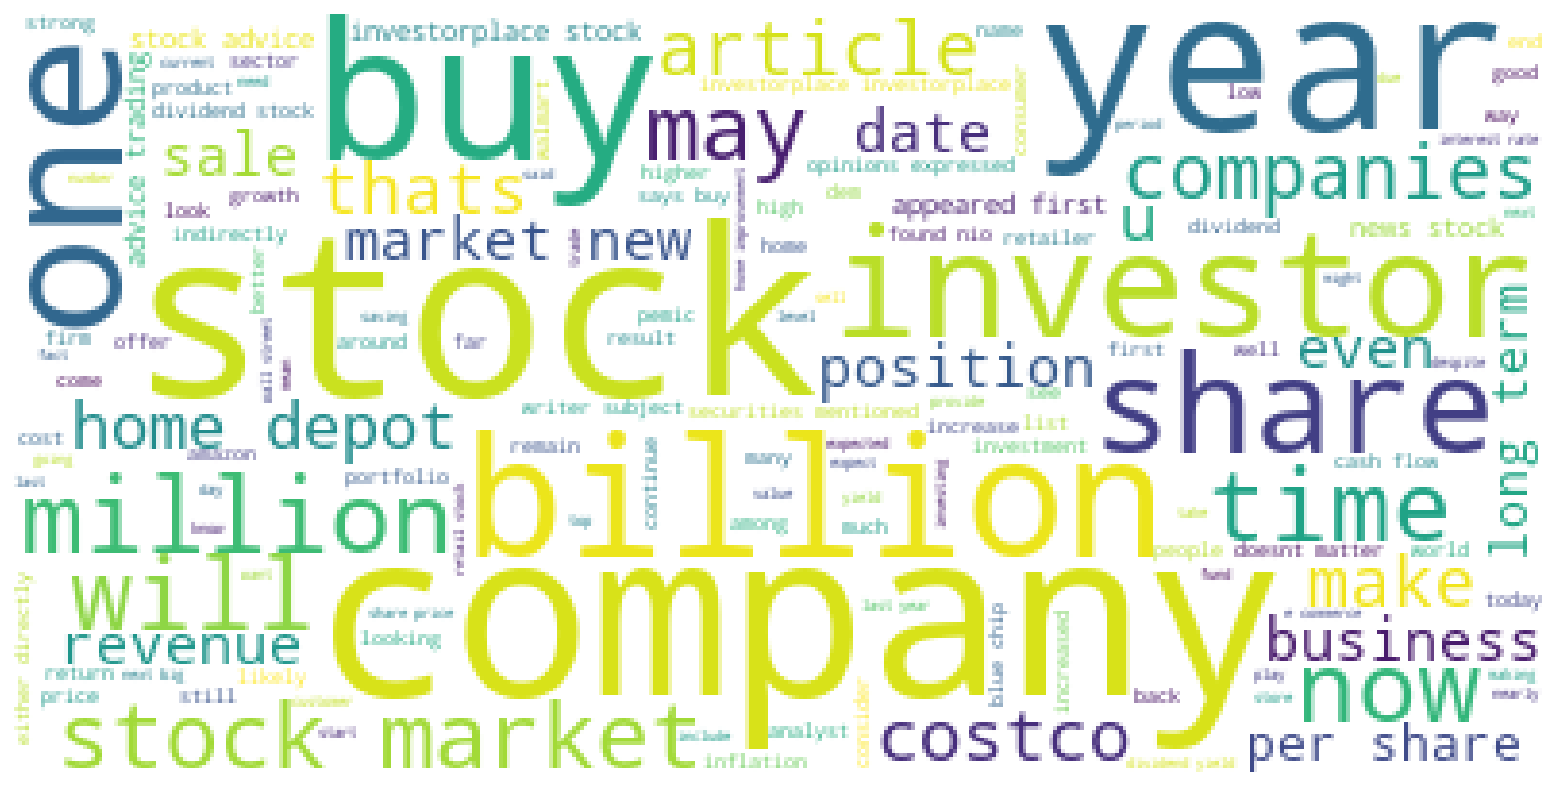

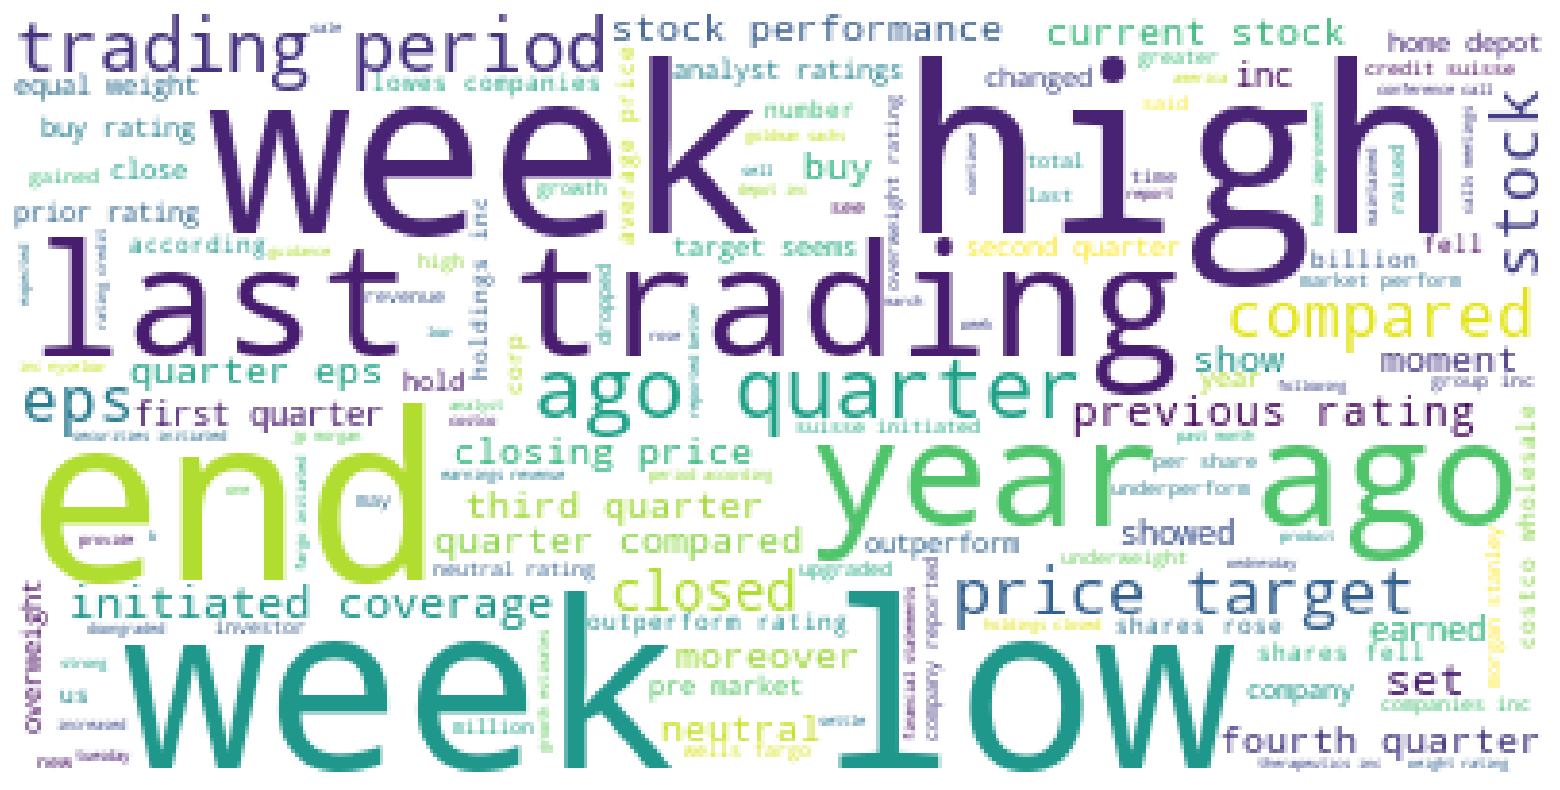

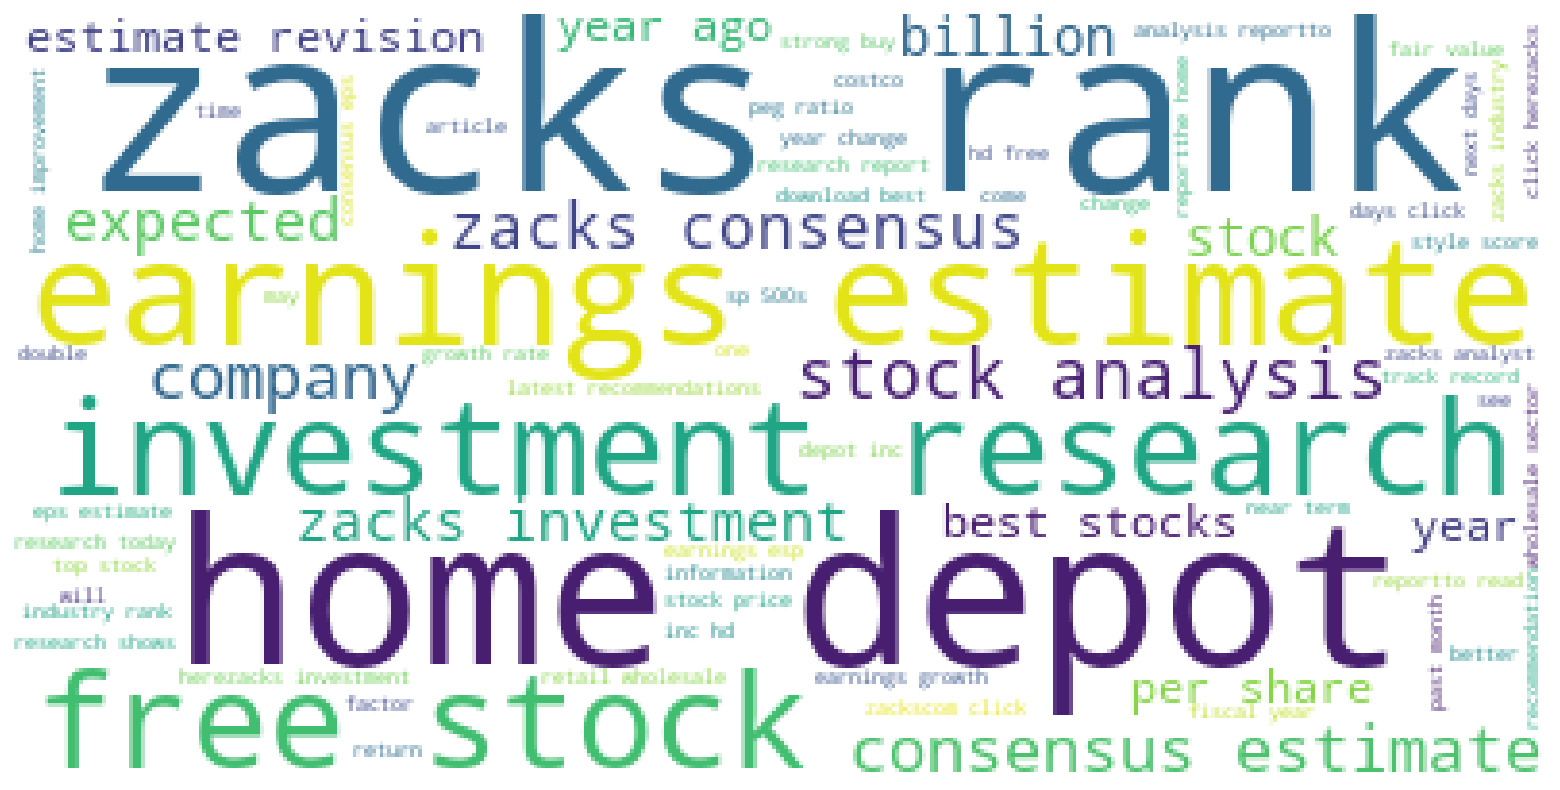

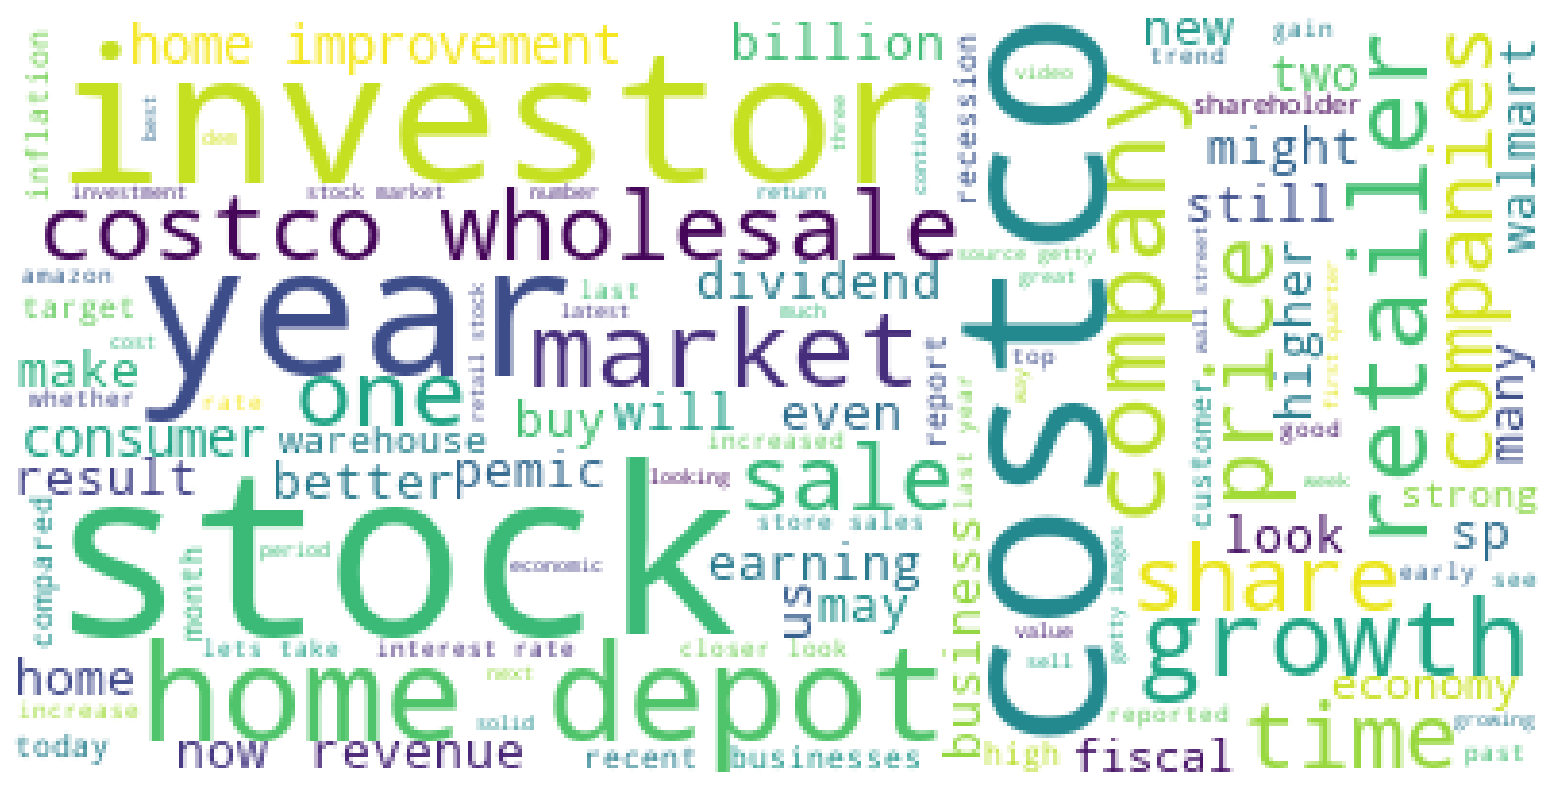

In [22]:
#word cloud to view top reoccuring words 
cloud = WordCloud(background_color='white', max_font_size=60, relative_scaling=.5).generate(' '.join(pj))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud);

cloud = WordCloud(background_color='white', max_font_size=60, relative_scaling=.5).generate(' '.join(bs))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud);

cloud = WordCloud(background_color='white', max_font_size=60, relative_scaling=.5).generate(' '.join(bl))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud);

cloud = WordCloud(background_color='white', max_font_size=60, relative_scaling=.5).generate(' '.join(jg))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud);

Topic modelling using bertopic

In [23]:
df = df.reset_index(drop=True)

In [24]:
from bertopic import BERTopic
# Dimension reduction
from umap import UMAP

In [25]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)
# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
# Run BERTopic model
topics, probabilities = topic_model.fit_transform(df['lemmas'])

Extracting topics from the model

In [26]:
# Get the list of topics
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,544,-1_stock_company_market_year
1,0,171,0_home_lowe_lowes_associate
2,1,84,1_home_depot_improvement_retailer
3,2,71,2_costco_retailer_wholesale_costcos
4,3,64,3_walmart_retail_sale_stock
5,4,63,4_insider_analyst_tiprankscom_report
6,5,55,5_dividend_yield_income_stock
7,6,53,6_percent_per_billion_bln
8,7,53,7_inflation_rate_buy_stock
9,8,51,8_break_deliver_wwwmarketwatchcom_tape


In [27]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=12)

In [28]:
# Visualize term rank decrease
topic_model.visualize_term_rank()

In [29]:
# Visualize intertopic distance
topic_model.visualize_topics()

In [30]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=10)

In [31]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

In [32]:
topic_model.visualize_distribution(topic_model.probabilities_[0], min_probability=0.015)

Evaluation of the topic models

In [33]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

texts = [text.split() for text in df['lemmas']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

topic_words = topic_model.get_topic_info()
topic_words = topic_words[["Topic", "Name"]]

top_words_per_topic = []
for _, row in topic_words.iterrows():
    words = row["Name"].split("_")
    top_words_per_topic.append(words)

coherence_model = CoherenceModel(topics=top_words_per_topic, texts=texts, dictionary=dictionary, coherence="c_v")
coherence_score = coherence_model.get_coherence()
print("Coherence score:", coherence_score)


Coherence score: 0.5535914106344421


In [34]:
def jaccard_similarity(topic1, topic2):
    set1, set2 = set(topic1), set(topic2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


def topic_diversity(top_words_per_topic, top_n=10):
    n_topics = len(top_words_per_topic)
    total_similarity = 0
    total_pairs = 0

    for i in range(n_topics):
        for j in range(i + 1, n_topics):
            similarity = jaccard_similarity(top_words_per_topic[i][:top_n], top_words_per_topic[j][:top_n])
            total_similarity += similarity
            total_pairs += 1

    average_similarity = total_similarity / total_pairs
    diversity = 1 - average_similarity
    return diversity


diversity = topic_diversity(top_words_per_topic)
print("Topic diversity:", diversity)



Topic diversity: 0.9825209769654214


Tunning the model

In [35]:
#using UMAP and an embeding model 

topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=50)
topics, _ = topic_model.fit_transform(df['lemmas'])
# Get the list of topics
topic_model.get_topic_info()

Batches: 100%|██████████| 70/70 [12:18<00:00, 10.55s/it]
2023-05-11 12:43:58,050 - BERTopic - Transformed documents to Embeddings
2023-05-11 12:44:28,338 - BERTopic - Reduced dimensionality
2023-05-11 12:44:28,864 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,240,-1_analyst_target_price_rating
1,0,1189,0_stock_company_year_market
2,1,331,1_zack_estimate_earning_stock
3,2,232,2_home_lowe_depot_lowes
4,3,86,3_fall_inc_share_report
5,4,74,4_52_week_quarter_rating
6,5,72,5_analyst_price_report_target


In [36]:
topic_model.visualize_barchart(top_n_topics=8, height=700)

In [37]:
topic_model.visualize_term_rank()

In [38]:
topic_model.visualize_term_rank(log_scale=True)

In [39]:
topic_model.visualize_hierarchy(top_n_topics=50, width=800)

Evaluating the model

In [40]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

texts = [text.split() for text in df['lemmas']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

topic_words = topic_model.get_topic_info()
topic_words = topic_words[["Topic", "Name"]]

top_words_per_topic = []
for _, row in topic_words.iterrows():
    words = row["Name"].split("_")
    top_words_per_topic.append(words)

coherence_model = CoherenceModel(topics=top_words_per_topic, texts=texts, dictionary=dictionary, coherence="c_v")
coherence_score = coherence_model.get_coherence()
print("Coherence score:", coherence_score)

Coherence score: 0.5990091437779492


####This code will give you the coherence score for the topics generated by BERTopic. A higher coherence score usually indicates better topic quality.

In [41]:
def jaccard_similarity(topic1, topic2):
    set1, set2 = set(topic1), set(topic2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


def topic_diversity(top_words_per_topic, top_n=10):
    n_topics = len(top_words_per_topic)
    total_similarity = 0
    total_pairs = 0

    for i in range(n_topics):
        for j in range(i + 1, n_topics):
            similarity = jaccard_similarity(top_words_per_topic[i][:top_n], top_words_per_topic[j][:top_n])
            total_similarity += similarity
            total_pairs += 1

    average_similarity = total_similarity / total_pairs
    diversity = 1 - average_similarity
    return diversity


diversity = topic_diversity(top_words_per_topic)
print("Topic diversity:", diversity)

Topic diversity: 0.963718820861678


####This code first defines a function jaccard_similarity() to compute the Jaccard similarity between two sets of words. The topic_diversity() function then calculates the average Jaccard similarity between all pairs of topics and subtracts it from 1 to compute the topic diversity. A higher diversity value (closer to 1) means that the topics are more distinct from each other, while a lower diversity value (closer to 0) means that the topics are more similar

We will take 2 clusters and pass it to the zero-shot model

In [42]:
# Modeling
from transformers import pipeline
classifier = pipeline(task="zero-shot-classification")#, 
#model="facebook/bart-mini-mnli",
# device=0)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


#####Based on the given words in the topic model, I can suggest two main topics to represent them as candidate_labels in a zero-shot model:

"Earnings and Financial Analysis": This topic would encompass words such as week, quarter, fall, inc, share, analyst, report, price, estimate, earning, and change. These words are related to financial performance, stock market analysis, and reporting periods.

"Home Improvement Retailers": This topic would include words like home, lowe, depot, stock, company, and year. These words are related to home improvement retail companies, such as Home Depot and Lowe's, and their performance over time.  "FinanceAnalysis", "HomeRetail"

In [43]:
from transformers import pipeline

# Initialize the zero-shot classification pipeline
classifier = pipeline(task="zero-shot-classification")

# Define the candidate labels
candidate_labels = ["FinanceAnalysis", "HomeRetail"]

# Set the hypothesis template
hypothesis_template = "The topic of this text is {}."

# Put the text column in a list
texts = df['lemmas'].to_list()

# Split the texts into smaller batches (e.g., 10 texts per batch)
batch_size = 10
text_batches = [texts[i:i+batch_size] for i in range(0, len(texts), batch_size)]

# Perform the zero-shot classification on each batch
predictions = []
for batch in text_batches:
    batch_predictions = classifier(batch, candidate_labels, hypothesis_template=hypothesis_template)
    predictions.extend(batch_predictions)

# Create an empty list to save the prediciton results
results = []

# Iterate over the predictions
for prediction in predictions:
    predicted_topic = prediction['labels'][0]
    predicted_score = prediction['scores'][0]
    results.append({'predicted_topic': predicted_topic, 'predicted_score': predicted_score})

# Create a dataframe from the list of results
result_df = pd.DataFrame(results)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [44]:
result_df['predicted_topic'].value_counts()

predicted_topic
HomeRetail         1146
FinanceAnalysis    1078
Name: count, dtype: int64

In [46]:
df = pd.merge(df, result_df, left_index=True, right_index=True)

In [48]:
df.sample(4)

,Source,Link,Title,Article,Date,tokens_column,lemmas,word_count,unique_word_count,mean_word_length,predicted_topic,predicted_score
1696,Benzinga,https://markets.businessinsider.com/news/etf/f...,famed ai based etf slashed tesla holding in ma...,the qraft ai enhanced us large cap momentum et...,2021-06-09,"[qraft, ai, enhanced, us, large, cap, momentum...",qraft ai enhance we large cap momentum etf nys...,307,193,5.247557,FinanceAnalysis,0.634106
99,Zacks,https://markets.businessinsider.com/news/stock...,zacks value trader highlights the home depot c...,for immediate releasechicago il march 24 2023 ...,2023-03-25,"[immediate, releasechicago, il, march, 24, 202...",immediate releasechicago il march 24 2023 zack...,1314,570,5.045662,FinanceAnalysis,0.508375
1499,InvestorPlace,https://markets.businessinsider.com/news/stock...,3 large cap stocks to buy on earnings dips.,investorplace stock market news stock advice t...,2022-05-17,"[investorplace, stock, market, news, stock, ad...",investorplace stock market news stock advice t...,898,431,4.842984,HomeRetail,0.628231
1124,TipRanks,https://markets.businessinsider.com/news/stock...,how climate change may benefit home depot stoc...,as climate change became a mainstream concern ...,2023-01-20,"[climate, change, became, mainstream, concern,...",climate change become mainstream concern busin...,722,417,5.337950,HomeRetail,0.717448


Normal Classification Algorithms

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [50]:
df1 = df.copy()

In [51]:
df1 = df1.drop('predicted_score', axis=1)

Decision Tree Classifier

In [52]:
# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', TfidfVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = DecisionTreeClassifier(random_state=42)

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic',axis=1)
y = df1['predicted_topic']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7752808988764045

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.77      0.75      0.76       214
     HomeRetail       0.78      0.80      0.79       231

       accuracy                           0.78       445
      macro avg       0.78      0.77      0.77       445
   weighted avg       0.78      0.78      0.78       445



Using count vectorizer

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', CountVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = DecisionTreeClassifier(random_state=42)

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic',axis=1)
y = df1['predicted_topic']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7910112359550562

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.78      0.79      0.78       214
     HomeRetail       0.80      0.80      0.80       231

       accuracy                           0.79       445
      macro avg       0.79      0.79      0.79       445
   weighted avg       0.79      0.79      0.79       445



Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier


# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', TfidfVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = RandomForestClassifier(random_state=42)

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7640449438202247

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.72      0.82      0.77       214
     HomeRetail       0.81      0.71      0.76       231

       accuracy                           0.76       445
      macro avg       0.77      0.77      0.76       445
   weighted avg       0.77      0.76      0.76       445



Modifying the text pre-processing step using countvectorizer

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', CountVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = RandomForestClassifier(random_state=42)

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.755056179775281

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.71      0.84      0.77       214
     HomeRetail       0.82      0.68      0.74       231

       accuracy                           0.76       445
      macro avg       0.76      0.76      0.75       445
   weighted avg       0.76      0.76      0.75       445



Support Vector Machines

In [54]:
from sklearn.svm import SVC

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', TfidfVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = SVC(random_state=42)

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7393258426966293

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.69      0.83      0.75       214
     HomeRetail       0.81      0.65      0.72       231

       accuracy                           0.74       445
      macro avg       0.75      0.74      0.74       445
   weighted avg       0.75      0.74      0.74       445



Using count Vectorizer

In [75]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', CountVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = SVC(random_state=42)

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7101123595505618

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.70      0.69      0.70       214
     HomeRetail       0.72      0.73      0.72       231

       accuracy                           0.71       445
      macro avg       0.71      0.71      0.71       445
   weighted avg       0.71      0.71      0.71       445



XgBoost 

In [73]:
from xgboost import XGBClassifier

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', TfidfVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Decode the predicted labels
y_pred_decoded = encoder.inverse_transform(y_pred)

# Decode the true labels
y_test_decoded = encoder.inverse_transform(y_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))


Accuracy: 0.7932584269662921

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.76      0.84      0.80       214
     HomeRetail       0.84      0.75      0.79       231

       accuracy                           0.79       445
      macro avg       0.80      0.80      0.79       445
   weighted avg       0.80      0.79      0.79       445



using count Vectorizer

In [74]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', CountVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Decode the predicted labels
y_pred_decoded = encoder.inverse_transform(y_pred)

# Decode the true labels
y_test_decoded = encoder.inverse_transform(y_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

Accuracy: 0.8089887640449438

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.77      0.86      0.81       214
     HomeRetail       0.85      0.77      0.81       231

       accuracy                           0.81       445
      macro avg       0.81      0.81      0.81       445
   weighted avg       0.81      0.81      0.81       445



Naive bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', TfidfVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = MultinomialNB()

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Decode the predictions
y_pred_decoded = encoder.inverse_transform(y_pred)

# Decode the true labels
y_test_decoded = encoder.inverse_transform(y_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

Accuracy: 0.5797752808988764

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.55      0.76      0.64       214
     HomeRetail       0.65      0.41      0.50       231

       accuracy                           0.58       445
      macro avg       0.60      0.59      0.57       445
   weighted avg       0.60      0.58      0.57       445



Using count vectorizer

In [77]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the data using a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['word_count', 'unique_word_count', 'mean_word_length']),
        ('text', CountVectorizer(), 'lemmas')
    ])

# Define the classifier
classifier = MultinomialNB()

# Combine the preprocessor and the classifier into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Extract the features and the target variable
X = df1.drop('predicted_topic', axis=1)
y = df1['predicted_topic']

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Decode the predictions
y_pred_decoded = encoder.inverse_transform(y_pred)

# Decode the true labels
y_test_decoded = encoder.inverse_transform(y_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

Accuracy: 0.7213483146067415

Classification Report:
                  precision    recall  f1-score   support

FinanceAnalysis       0.76      0.62      0.68       214
     HomeRetail       0.70      0.81      0.75       231

       accuracy                           0.72       445
      macro avg       0.73      0.72      0.72       445
   weighted avg       0.73      0.72      0.72       445



Deep learning models

In [93]:
#create a temporary copy 
df_copy = df.copy()

In [91]:
#df.to_csv('MI_topics.csv', index=False)

In [94]:
#drop unwanted columns
df_copy.drop(['Date', 'Link', 'Title', 'Source', 'Article', 'tokens_column', 'word_count', 'unique_word_count','mean_word_length', 'predicted_score'],axis=1,inplace=True)

In [95]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lemmas           2224 non-null   object
 1   predicted_topic  2224 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [96]:
#create input and output vectors 
X = df_copy.lemmas
Y = df_copy.predicted_topic
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [97]:
#splitinto training and test dataset
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

Tokenize the data and convert the text to sequences.
Add padding to ensure that all the sequences have the same shape.
There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [98]:
from tensorflow import keras
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Assuming X_train is your training dataset
tok = Tokenizer()
tok.fit_on_texts(X_train)

# Get the number of unique words
vocab_size = len(tok.word_index)
print(f"Vocabulary size: {vocab_size}")

# Calculate the cumulative percentage of words captured by a certain max_words value
max_words = 25000
cumulative_percentage = sum(tok.word_counts[word] for word, idx in tok.word_index.items() if idx <= max_words) / sum(tok.word_counts.values())
print(f"Cumulative percentage of words captured by max_words={max_words}: {cumulative_percentage * 100:.2f}%")


Vocabulary size: 58007
Cumulative percentage of words captured by max_words=25000: 96.38%


In [67]:
article_lengths = [len(article.split()) for article in X_train]

# Calculate the percentile
max_len = int(np.percentile(article_lengths, 95)) 

In [100]:
max_words = 15000
embedding_dim = 50
# Calculate max_len based on the 95th percentile of article lengths
article_lengths = [len(article.split()) for article in X_train]
max_len = int(np.percentile(article_lengths, 95))
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

Recurent Neural Network

In [101]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [102]:
#Call the function and compile the model.

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1272)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1272, 50)          750000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [103]:
#Fit on the training data.

history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,) #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
12/12 [==============================] - 78s 6s/step - loss: 0.6921 - accuracy: 0.5562 - val_loss: 0.6505 - val_accuracy: 0.7116
Epoch 2/10
12/12 [==============================] - 69s 6s/step - loss: 0.6177 - accuracy: 0.7196 - val_loss: 0.5750 - val_accuracy: 0.7593
Epoch 3/10
12/12 [==============================] - 70s 6s/step - loss: 0.5117 - accuracy: 0.7778 - val_loss: 0.4980 - val_accuracy: 0.7513
Epoch 4/10
12/12 [==============================] - 67s 6s/step - loss: 0.5261 - accuracy: 0.7672 - val_loss: 0.5058 - val_accuracy: 0.7513
Epoch 5/10
12/12 [==============================] - 65s 5s/step - loss: 0.3967 - accuracy: 0.8538 - val_loss: 0.4927 - val_accuracy: 0.7302
Epoch 6/10
12/12 [==============================] - 64s 5s/step - loss: 0.3264 - accuracy: 0.8829 - val_loss: 0.5085 - val_accuracy: 0.7037
Epoch 7/10
12/12 [==============================] - 66s 6s/step - loss: 0.2586 - accuracy: 0.9134 - val_loss: 0.7176 - val_accuracy: 0.6667
Epoch 8/10
12/12 [==

BiRNN

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1272, 50)          750000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16128     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [105]:
num_epochs = 10
history = model.fit(sequences_matrix, Y_train, epochs=num_epochs, batch_size=64, validation_split=0.2)

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
24/24 [==============================] - 67s 2s/step - loss: 2.3747 - accuracy: 0.6025 - val_loss: 2.2216 - val_accuracy: 0.4709
Epoch 2/10
24/24 [==============================] - 44s 2s/step - loss: 1.9645 - accuracy: 0.6819 - val_loss: 1.9159 - val_accuracy: 0.4709
Epoch 3/10
24/24 [==============================] - 41s 2s/step - loss: 1.5606 - accuracy: 0.7897 - val_loss: 1.6478 - val_accuracy: 0.4709
Epoch 4/10
24/24 [==============================] - 40s 2s/step - loss: 1.1566 - accuracy: 0.8743 - val_loss: 1.4006 - val_accuracy: 0.4735
Epoch 5/10
24/24 [==============================] - 44s 2s/step - loss: 0.8536 - accuracy: 0.9206 - val_loss: 1.1934 - val_accuracy: 0.5212
Epoch 6/10
24/24 [==============================] - 43s 2s/step - loss: 0.6160 - accuracy: 0.9451 - val_loss: 1.0618 - val_accuracy: 0.4894
Epoch 7/10
24/24 [==============================] - 41s 2s/step - loss: 0.4484 - accuracy: 0.9530 - val_loss: 0.9288 - val_accuracy: 0.5608
Epoch 8/10
24/24 [==

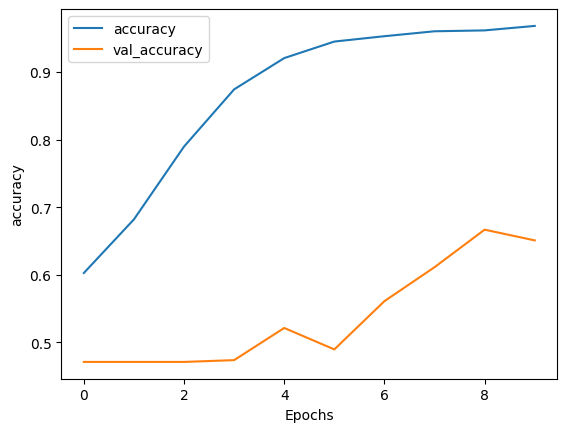

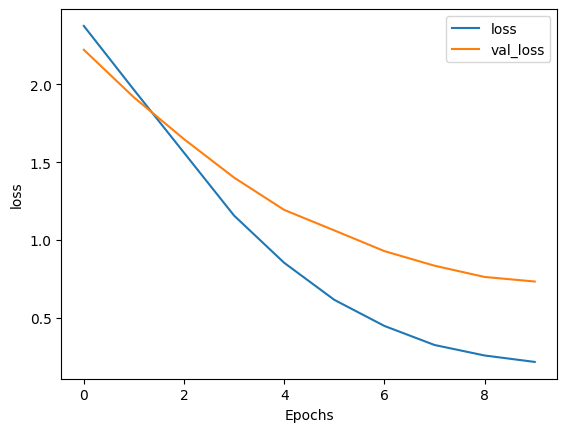

In [106]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [107]:
# Model Definition with BiRNN (GRU)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1272, 50)          750000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16128     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [108]:
num_epochs = 10
history = model.fit(sequences_matrix, Y_train, epochs=num_epochs, batch_size=64, validation_split=0.2)

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
24/24 [==============================] - 59s 2s/step - loss: 0.8942 - accuracy: 0.5807 - val_loss: 0.8915 - val_accuracy: 0.4709
Epoch 2/10
24/24 [==============================] - 43s 2s/step - loss: 0.7882 - accuracy: 0.6594 - val_loss: 0.8572 - val_accuracy: 0.4709
Epoch 3/10
24/24 [==============================] - 46s 2s/step - loss: 0.6501 - accuracy: 0.7685 - val_loss: 0.8242 - val_accuracy: 0.4735
Epoch 4/10
24/24 [==============================] - 47s 2s/step - loss: 0.4467 - accuracy: 0.8763 - val_loss: 0.7925 - val_accuracy: 0.5159
Epoch 5/10
24/24 [==============================] - 46s 2s/step - loss: 0.3316 - accuracy: 0.9187 - val_loss: 0.7654 - val_accuracy: 0.5741
Epoch 6/10
24/24 [==============================] - 48s 2s/step - loss: 0.2704 - accuracy: 0.9358 - val_loss: 0.7682 - val_accuracy: 0.5212
Epoch 7/10
24/24 [==============================] - 47s 2s/step - loss: 0.2208 - accuracy: 0.9438 - val_loss: 0.7572 - val_accuracy: 0.5265
Epoch 8/10
24/24 [==

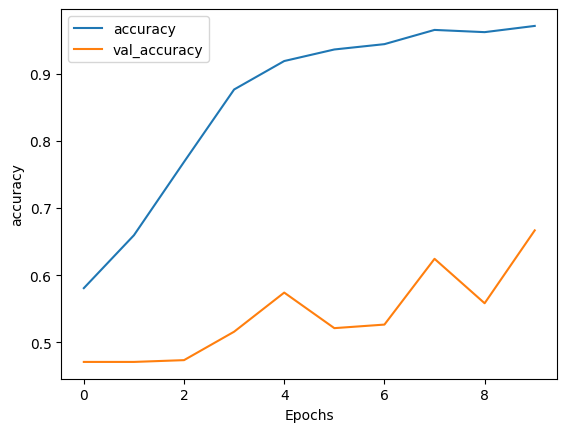

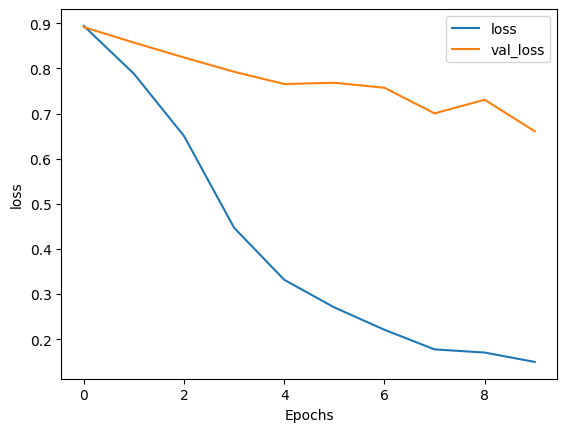

In [110]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

RNN with LSTM

In [111]:
# Model Definition with BiRNN (LSTM)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1272, 50)          750000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               21248     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [112]:
num_epochs = 10
history = model.fit(sequences_matrix, Y_train, epochs=num_epochs, batch_size=64, validation_split=0.2)

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
24/24 [==============================] - 157s 6s/step - loss: 2.3871 - accuracy: 0.5966 - val_loss: 2.2185 - val_accuracy: 0.4709
Epoch 2/10
24/24 [==============================] - 143s 6s/step - loss: 1.9247 - accuracy: 0.7235 - val_loss: 1.8856 - val_accuracy: 0.4709
Epoch 3/10
24/24 [==============================] - 148s 6s/step - loss: 1.4446 - accuracy: 0.8406 - val_loss: 1.5909 - val_accuracy: 0.5370
Epoch 4/10
24/24 [==============================] - 147s 6s/step - loss: 1.0505 - accuracy: 0.9094 - val_loss: 1.3465 - val_accuracy: 0.5370
Epoch 5/10
24/24 [==============================] - 147s 6s/step - loss: 0.7441 - accuracy: 0.9444 - val_loss: 1.1239 - val_accuracy: 0.6085
Epoch 6/10
24/24 [==============================] - 140s 6s/step - loss: 0.5014 - accuracy: 0.9676 - val_loss: 0.9634 - val_accuracy: 0.6772
Epoch 7/10
24/24 [==============================] - 143s 6s/step - loss: 0.3662 - accuracy: 0.9755 - val_loss: 0.7969 - val_accuracy: 0.7460
Epoch 8/10
24

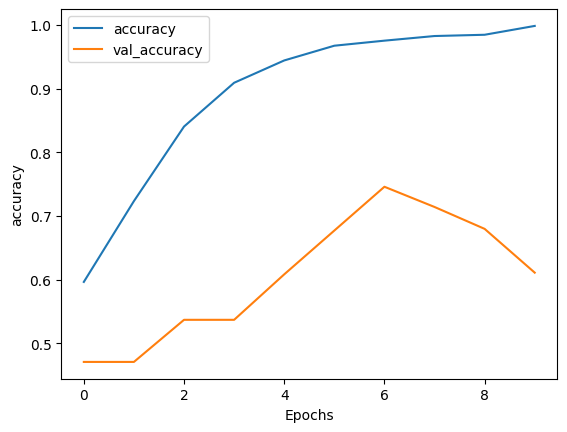

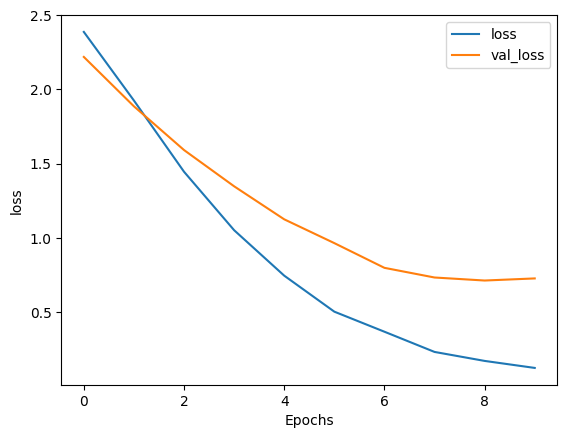

In [113]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [114]:
# Model Definition with BiRNN (LSTM)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1272, 50)          750000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               21248     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_3 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [115]:
num_epochs = 10
history = model.fit(sequences_matrix, Y_train, epochs=num_epochs, batch_size=64, validation_split=0.2)

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
24/24 [==============================] - 148s 6s/step - loss: 0.8758 - accuracy: 0.6071 - val_loss: 0.8837 - val_accuracy: 0.4709
Epoch 2/10
24/24 [==============================] - 138s 6s/step - loss: 0.6653 - accuracy: 0.7870 - val_loss: 0.8433 - val_accuracy: 0.4709
Epoch 3/10
24/24 [==============================] - 142s 6s/step - loss: 0.4803 - accuracy: 0.8651 - val_loss: 0.8144 - val_accuracy: 0.4735
Epoch 4/10
24/24 [==============================] - 143s 6s/step - loss: 0.3302 - accuracy: 0.9233 - val_loss: 0.7898 - val_accuracy: 0.4921
Epoch 5/10
24/24 [==============================] - 140s 6s/step - loss: 0.2498 - accuracy: 0.9418 - val_loss: 0.7341 - val_accuracy: 0.6587
Epoch 6/10
24/24 [==============================] - 136s 6s/step - loss: 0.1760 - accuracy: 0.9762 - val_loss: 0.6891 - val_accuracy: 0.7407
Epoch 7/10
24/24 [==============================] - 135s 6s/step - loss: 0.1474 - accuracy: 0.9769 - val_loss: 0.6643 - val_accuracy: 0.6799
Epoch 8/10
24

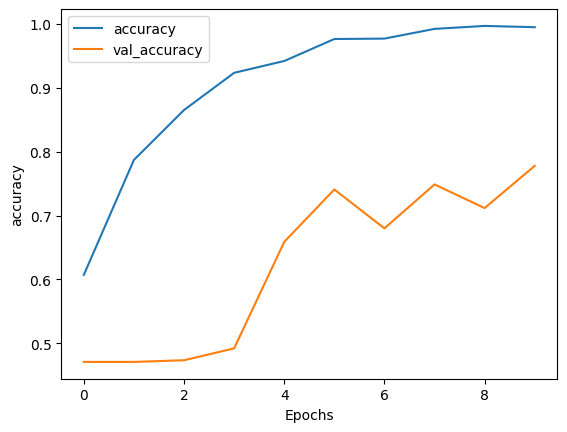

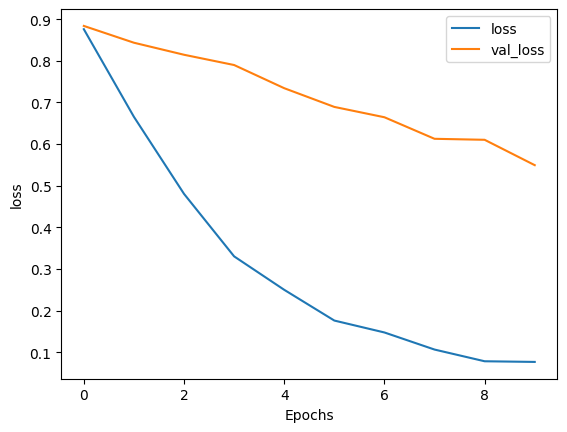

In [116]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

Convolutional neural network

In [117]:
# Model Definition with CNN (Conv1D)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1272, 50)          750000    
                                                                 
 conv1d (Conv1D)             (None, 1268, 128)         32128     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 100)               12900     
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 100)              

In [118]:
num_epochs = 10
history = model.fit(sequences_matrix, Y_train, epochs=num_epochs, batch_size=64, validation_split=0.2)

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
24/24 [==============================] - 18s 578ms/step - loss: 3.4314 - accuracy: 0.5866 - val_loss: 3.0349 - val_accuracy: 0.4709
Epoch 2/10
24/24 [==============================] - 13s 552ms/step - loss: 2.6281 - accuracy: 0.7077 - val_loss: 2.3594 - val_accuracy: 0.4709
Epoch 3/10
24/24 [==============================] - 13s 559ms/step - loss: 1.8820 - accuracy: 0.7950 - val_loss: 1.8218 - val_accuracy: 0.4788
Epoch 4/10
24/24 [==============================] - 13s 551ms/step - loss: 1.2690 - accuracy: 0.8651 - val_loss: 1.4144 - val_accuracy: 0.4735
Epoch 5/10
24/24 [==============================] - 13s 555ms/step - loss: 0.8276 - accuracy: 0.9153 - val_loss: 1.1095 - val_accuracy: 0.5344
Epoch 6/10
24/24 [==============================] - 13s 553ms/step - loss: 0.5224 - accuracy: 0.9464 - val_loss: 0.9186 - val_accuracy: 0.5741
Epoch 7/10
24/24 [==============================] - 13s 546ms/step - loss: 0.3627 - accuracy: 0.9544 - val_loss: 0.8220 - val_accuracy: 0.6878

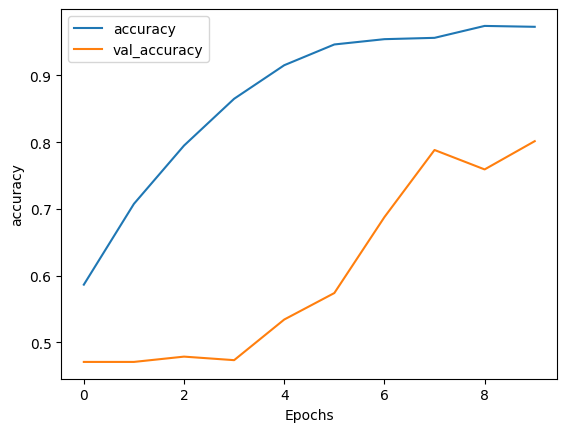

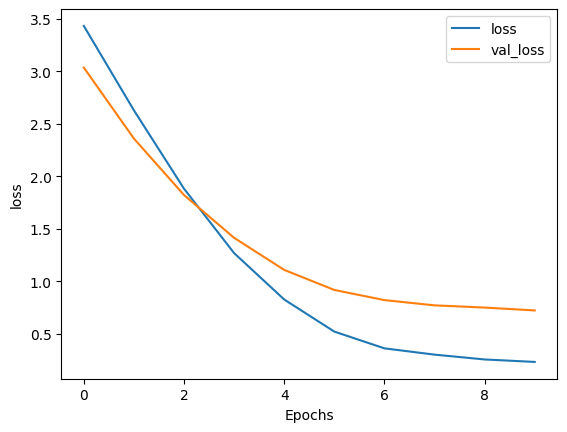

In [119]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [120]:
# Model Definition with CNN (Conv1D)
# with L2 Ridge Regularization
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1272, 50)          750000    
                                                                 
 conv1d_1 (Conv1D)           (None, 1268, 128)         32128     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 100)               12900     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                      

In [121]:
num_epochs = 10
history = model.fit(sequences_matrix, Y_train, epochs=num_epochs, batch_size=64, validation_split=0.2)

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
24/24 [==============================] - 16s 520ms/step - loss: 0.9729 - accuracy: 0.5384 - val_loss: 0.9134 - val_accuracy: 0.5026
Epoch 2/10
24/24 [==============================] - 12s 483ms/step - loss: 0.8638 - accuracy: 0.5410 - val_loss: 0.8262 - val_accuracy: 0.5185
Epoch 3/10
24/24 [==============================] - 12s 489ms/step - loss: 0.7837 - accuracy: 0.6025 - val_loss: 0.7581 - val_accuracy: 0.6032
Epoch 4/10
24/24 [==============================] - 12s 483ms/step - loss: 0.7245 - accuracy: 0.6323 - val_loss: 0.7314 - val_accuracy: 0.5952
Epoch 5/10
24/24 [==============================] - 12s 484ms/step - loss: 0.6837 - accuracy: 0.6508 - val_loss: 0.6984 - val_accuracy: 0.6111
Epoch 6/10
24/24 [==============================] - 12s 486ms/step - loss: 0.6200 - accuracy: 0.7196 - val_loss: 0.6442 - val_accuracy: 0.6878
Epoch 7/10
24/24 [==============================] - 12s 489ms/step - loss: 0.5154 - accuracy: 0.7937 - val_loss: 0.5823 - val_accuracy: 0.7222

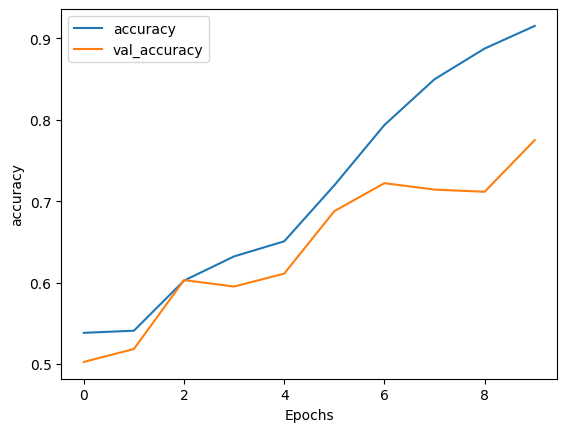

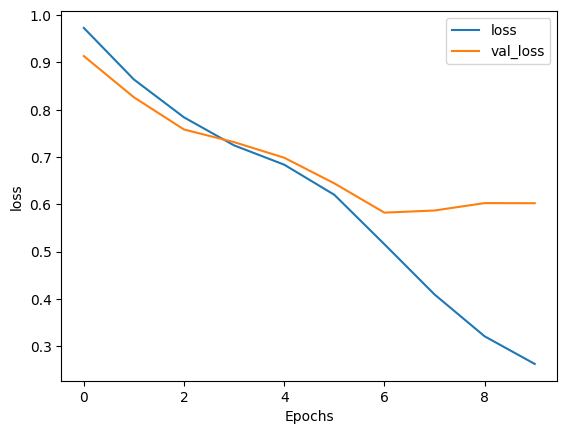

In [122]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

CNN-RNN combined architecture¶
For the prediction of article topics, we will use the following architecture:
Combination of CNN-RNN (LSTM)
Output from CNN with Conv1D is used as input for RNN with LSTM (with Lasso Regularization, Dropout)

In [123]:
# Model Definition with CNN (Conv1D)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Conv1D(128, 1, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding="same"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1272, 50)          750000    
                                                                 
 conv1d_2 (Conv1D)           (None, 1272, 128)         6528      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 636, 128)         0         
 )                                                               
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 100)               6500      
                                                                 
 dropout_10 (Dropout)        (None, 100)              

In [124]:
num_epochs = 10
history = model.fit(sequences_matrix, Y_train, epochs=num_epochs, batch_size=64, validation_split=0.2)

# Preprocess the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

# Evaluate the model on the training and test sets
train_accuracy = model.evaluate(sequences_matrix, Y_train)[1]
test_accuracy = model.evaluate(test_sequences_matrix, Y_test)[1]

# Print training, validation, and test accuracies
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy: {:.2f}".format(test_accuracy))

Epoch 1/10
24/24 [==============================] - 141s 5s/step - loss: 3.4430 - accuracy: 0.5231 - val_loss: 3.0686 - val_accuracy: 0.4709
Epoch 2/10
24/24 [==============================] - 124s 5s/step - loss: 2.7495 - accuracy: 0.5906 - val_loss: 2.3970 - val_accuracy: 0.7381
Epoch 3/10
24/24 [==============================] - 124s 5s/step - loss: 2.1260 - accuracy: 0.7057 - val_loss: 1.8302 - val_accuracy: 0.7381
Epoch 4/10
24/24 [==============================] - 124s 5s/step - loss: 1.5629 - accuracy: 0.8069 - val_loss: 1.3484 - val_accuracy: 0.7725
Epoch 5/10
24/24 [==============================] - 122s 5s/step - loss: 1.1114 - accuracy: 0.8651 - val_loss: 1.0297 - val_accuracy: 0.7963
Epoch 6/10
24/24 [==============================] - 126s 5s/step - loss: 0.7692 - accuracy: 0.9021 - val_loss: 0.8915 - val_accuracy: 0.7328
Epoch 7/10
24/24 [==============================] - 127s 5s/step - loss: 0.5291 - accuracy: 0.9292 - val_loss: 0.7314 - val_accuracy: 0.7963
Epoch 8/10
24

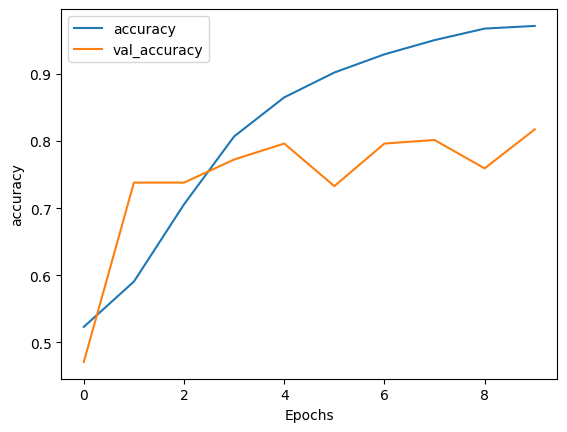

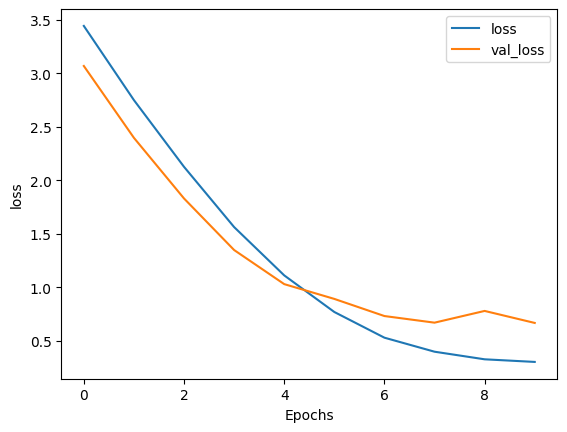

In [125]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()